This notebook is a supplement to the paper ["The Orthologic of Epistemic Modals"](https://escholarship.org/uc/item/0ss5z8g3) by [Wesley H. Holliday](mailto:wesholliday@berkeley.edu) and [Matthew Mandelkern](mandelkern@nyu.edu). The notebook focuses on the *possibility semantics* for modal orthologic discussed in Section 4 of the paper.

To view the notebook online, type the URL of this notebook (https://github.com/wesholliday/ortho-modals/blob/main/poss-semantics.ipynb) into the location field at https://nbviewer.org. GitHub's preview of the notebook might not show all the output that was generated.


# Notebook Outline

### 1. Compatibility frames

#### 1.1 The compatibility frame for the Epistemic Scale
#### 1.2 The compatibility frame for the Epistemic Grid

### 2. The ortholattice of regular sets

#### 1.1 The ortholattices from the Epistemic Scale
#### 1.2 The ortholattices from the Epistemic Grid

### 3. Hasse diagrams of the lattices

#### 3.1 Displaying the ortholattices from the Epistemic Scale
#### 3.2 Displaying the ortholattices from the Epistemic Grid

### 4. Operations on regular sets

### 5. Compatibility frames with the same refinement relation but non-isomorphic ortholattices

### 6. Adding accessibility
#### 6.1 Accessibility for the Epistemic Scale
#### 6.2 Accessibility for the Epistemic Grid

### 7. Interpreting formulas

### 8. Epistemic levels

In [107]:
import copy
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout

## 1. Compatibility frames

In [108]:
# when defining compatibility frames, 
# in order to avoid entering pairs (x,x) manually, we use the following:

def reflexive_closure(rel,X):
    """given a binary relation rel on X, returns the reflexive closure of rel"""
    relset = set(rel)

    for x in X:
        if not (x,x) in relset:
            rel.append((x,x))
    return rel

In [109]:
def domain(rel):
    """given a relation assumed to be reflexive, returns the domain of the relation"""
    X = {pair[0] for pair in rel}
    
    return X

In [110]:
def draw_digraph(rel,X = None):
    """given a relation rel on X, draw the digraph (with no loops) for rel;
    if no X is given, we assume rel is reflexive and take X to be the domain of rel"""
    
    if X is None:
        X = domain(rel)
    
    g = nx.DiGraph()
    g.add_nodes_from(X)
    
    for pair in rel:
        if not pair[0] == pair[1]:
            g.add_edge(pair[0],pair[1])
    
    nx.draw(g,with_labels=True)
    plt.show() 

### 1.1 The compatibilty frame for the Epistemic Scale

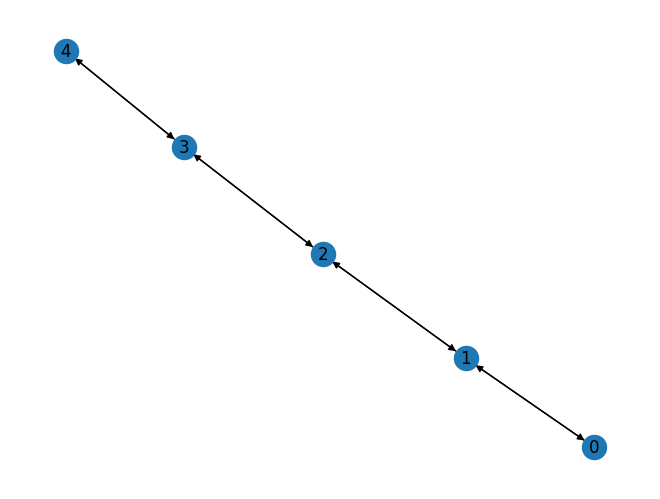

In [111]:
scale_rel = reflexive_closure([(0,1),(1,0),(1,2),(2,1),(2,3),(3,2),(3,4),(4,3)],range(5))
draw_digraph(scale_rel)

### 1.2 The compatibilty frame for the Epistemic Grid

As described in Example 4.33, the Epistemic Grid comes from the Epistemic Scale by a product construction.

In [112]:
prod = []
for x in range(5):
    for y in range (5):
        prod.append((x,y))

In [113]:
grid_rel = []
for pair in prod:
    for pair2 in prod:
        if abs(pair[0]-pair2[0])<=1 and abs(pair[1]-pair2[1])<=1: 
            grid_rel.append((pair,pair2))

In [114]:
print(grid_rel)

[((0, 0), (0, 0)), ((0, 0), (0, 1)), ((0, 0), (1, 0)), ((0, 0), (1, 1)), ((0, 1), (0, 0)), ((0, 1), (0, 1)), ((0, 1), (0, 2)), ((0, 1), (1, 0)), ((0, 1), (1, 1)), ((0, 1), (1, 2)), ((0, 2), (0, 1)), ((0, 2), (0, 2)), ((0, 2), (0, 3)), ((0, 2), (1, 1)), ((0, 2), (1, 2)), ((0, 2), (1, 3)), ((0, 3), (0, 2)), ((0, 3), (0, 3)), ((0, 3), (0, 4)), ((0, 3), (1, 2)), ((0, 3), (1, 3)), ((0, 3), (1, 4)), ((0, 4), (0, 3)), ((0, 4), (0, 4)), ((0, 4), (1, 3)), ((0, 4), (1, 4)), ((1, 0), (0, 0)), ((1, 0), (0, 1)), ((1, 0), (1, 0)), ((1, 0), (1, 1)), ((1, 0), (2, 0)), ((1, 0), (2, 1)), ((1, 1), (0, 0)), ((1, 1), (0, 1)), ((1, 1), (0, 2)), ((1, 1), (1, 0)), ((1, 1), (1, 1)), ((1, 1), (1, 2)), ((1, 1), (2, 0)), ((1, 1), (2, 1)), ((1, 1), (2, 2)), ((1, 2), (0, 1)), ((1, 2), (0, 2)), ((1, 2), (0, 3)), ((1, 2), (1, 1)), ((1, 2), (1, 2)), ((1, 2), (1, 3)), ((1, 2), (2, 1)), ((1, 2), (2, 2)), ((1, 2), (2, 3)), ((1, 3), (0, 2)), ((1, 3), (0, 3)), ((1, 3), (0, 4)), ((1, 3), (1, 2)), ((1, 3), (1, 3)), ((1, 3), 

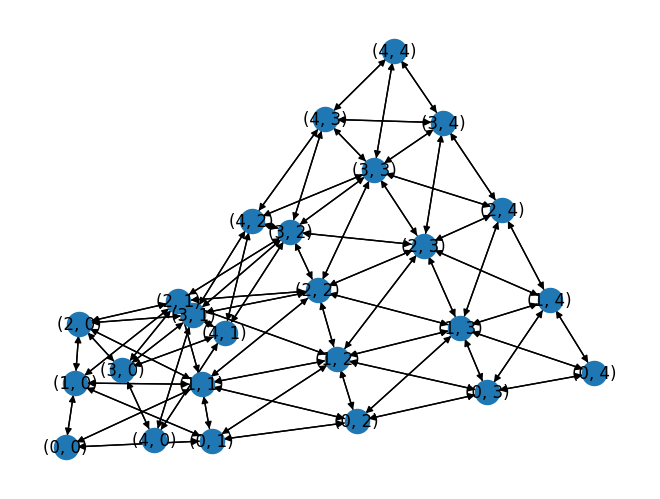

In [115]:
draw_digraph(grid_rel)

## 2. The ortholattice of regular sets

Given a compatibility frame $(S,\between)$, consider the closure operator $c_\between: \wp(S)\to \wp(S)$ defined by $c_\between(A)=\{x\in S\mid \forall y\between x\,\exists z\between y: z\in A\}$.

What we call "$\between$-regular sets" in the paper are fixpoints of $c_\between$, i.e., sets $A\subseteq S$ such that $c_\between(A)=A$.

In [116]:
def closure(A,rel,X = None):
    """given a subset A of X, returns the closure of A according to the closure operator
    defined from the compatibility relation rel as above;
    if no X is given, we assume rel is reflexive and take X to be the domain of rel"""

    if X is None:
        X = domain(rel)
    
    Aset = set(A)
    Xset = set(X)
    closure = [x for x in A]
   
    for x in Xset - Aset:
        x_sees = {y for y in X if (y,x) in rel}
        sees_into_A = {y for y in X if any([pair[0] in Aset and pair[1]==y for pair in rel])}
        if x_sees.issubset(sees_into_A):
            closure.append(x)
        
    return closure

For small compatibility frames, we can simply check for each subset whether it is a fixpoint of the closure operator.

In [117]:
def fixpoints_slow(rel,X = None):
    """given a binary relation rel on X, returns the fixpoints of the closure operator defined above"""

    if X is None:
        X = domain(rel)
    
    fixpts = [(), tuple(X)]
    
    pwrset = powerset(X)

    for A in pwrset:
        if A == () or A == tuple(X):
            continue
            
        if A == tuple(closure(A,rel,X)):
            fixpts.append(A)

    return fixpts

To handle larger compatibility frames, we can use Ganter's algorithm to calculate fixpoints of a closure operator (Ganter B. (2010), "Two Basic Algorithms in Concept Analysis." In: Kwuida L., Sertkaya B. (eds) Formal Concept Analysis. ICFCA 2010. *Lecture Notes in Computer Science*, vol 5986. Springer, Berlin, Heidelberg. https://doi.org/10.1007/978-3-642-11928-6_22). 

Ganter's algorithm assumes a closure operator on the powerset of a set $X$ where $X$ is an initial segment of the natural numbers (or otherwise linearly ordered). Thus, we include a function to convert a given compatibility frame to an isomorphic copy whose domain is an initial segment of the natural numbers.

In [118]:
def convert_to_nums(rel, X = None):
    """Given a compatibility frame, return an isomorphic copy
    whose domain is an initial segment of the natural numbers plus
    a dictionary to go back from natural numbers to the original elements"""
    
    if X is None:
        X = domain(rel)
    
    forward_map = {}
    inverse_map = {}
    count = 0
    
    for x in X:
        forward_map[x] = count
        inverse_map[count] = x
        count += 1  
    
    newrel = []
    
    for pair in rel:
        newrel.append((forward_map[pair[0]],forward_map[pair[1]]))
    
    return newrel, inverse_map

We implement the algorithm on p. 316 of Ganter's paper with the following two functions.

In [119]:
def next_fixpoint(A, rel, X = None):
    """Given a compatibility relation rel on an initial segment of the natural numbers
    and a subset A, assumed to be a fixpoint, calculate the next fixpoint
    according to Ganter's lectic ordering"""
    
    if X is None:
        X = domain(rel)
        
    Aset = set(A)
    
    for i in reversed(X):
        if not i in Aset:
            iset = set(range(i))
            inter = Aset.intersection(iset)
            union = inter.union({i})
            Anext = closure(union, rel, X)
            if [j for j in Anext if j<i and not j in Aset] == []:
                return tuple(Anext) 

In [120]:
def fixpoints(rel, X = None):
    """Given a compatibility relation rel, return the fixpoints according to Ganter's algorithm;
    if rel is not already on an initial segment of the natural numbers, 
    apply convert_to_nums in order to run next_fixpoint and then apply 
    the inverse map to get corresponding fixpoints for the original rel"""
    
    if X is None:
        X = domain(rel)
        
    if tuple(X) == tuple(range(len(X))):
        
        listX = list(X)
        setX = set(X)
    
        fixpts = [set()]
        A = ()
    
        while not set(A) == setX:
            A_next = next_fixpoint(A,rel,listX)
            A = A_next
            fixpts.append(set(A_next))
        
        return fixpts
    
    else:
        conv = convert_to_nums(rel, X)
        newrel = conv[0]
        inverse = conv[1]
        newX = domain(newrel)
        
        listX = list(newX)
        setX = set(newX)
        
        fixpts = [set()]
        A = ()
    
        while not set(A) == setX:
            A_next = next_fixpoint(A,newrel,listX)
            A = A_next
            A_next_inverse = tuple({inverse[a] for a in A_next})
            fixpts.append(set(A_next_inverse))
        
        return fixpts

### 2.1 The ortholattice for the Epistemic Scale

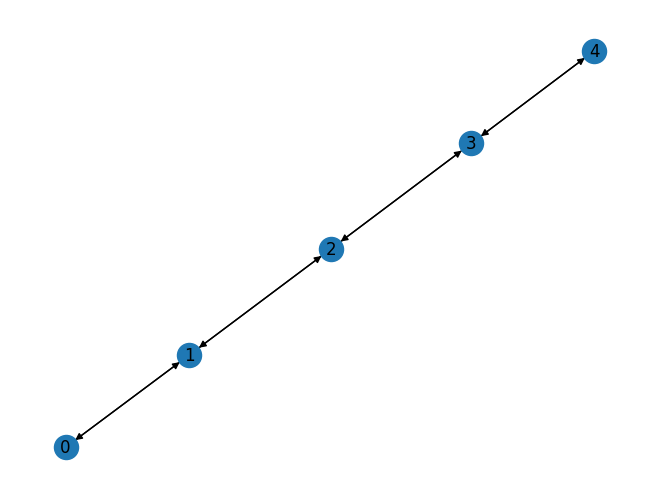

In [121]:
#Recall the compatibility frame for the Epistemic Scale
draw_digraph(scale_rel)

In [122]:
scale_lat = fixpoints(scale_rel)
print(len(scale_lat))
print(scale_lat)

10
[set(), {4}, {3, 4}, {2}, {2, 3, 4}, {0}, {0, 4}, {0, 1}, {0, 1, 2}, {0, 1, 2, 3, 4}]


### 2.2 The ortholattice for the Epistemic Grid

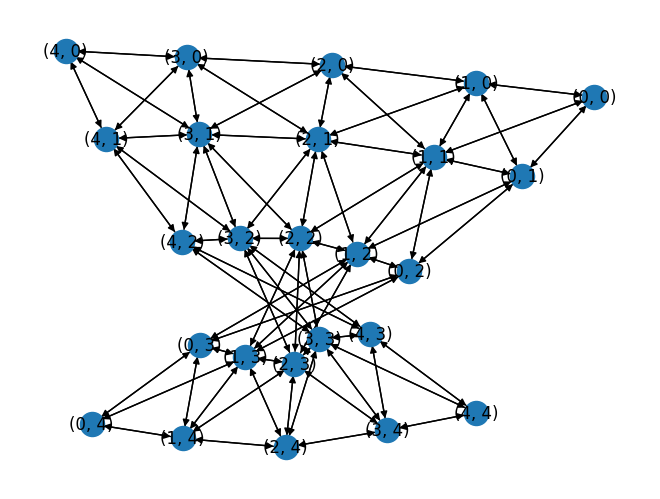

In [123]:
#Recall the compatibility frame for the Epistemic Grid
draw_digraph(grid_rel)

In [124]:
grid_lat = fixpoints(grid_rel)

In [125]:
len(grid_lat)

1942

## 3. Hasse diagrams of the lattices

Given a family of regular sets, we first calculate the proper subset relation between them, then calculate the associated covering relation, and finally create a networkx digraph for the Hasse diagram of the lattice of regular sets.

In [126]:
def propsubrel(lt):
    """given a list of tuples representing a set of sets, returns the proper subset relation as a list of pairs"""
    propsubrel = []
    
    for A in lt:
        for B in lt:  
            if set(A).issubset(set(B)) and not set(B).issubset(set(A)):
                propsubrel.append((A,B))
                
    return propsubrel

In [127]:
def covering(spo):
    """given a strict partial order spo, returns the associated covering relation"""
    cover = copy.deepcopy(spo)
    for p1 in spo:
        for p2 in spo:
            if p1 in cover and p1[0] == p2[0] and (p2[1],p1[1]) in spo:
                cover.remove(p1)
                break
    return cover

In [128]:
def lattice(regsets):
    """given a family of regular sets, returns the Hasse diagram of the lattice of regular sets"""
        
    regtuples = [tuple(A) for A in regsets]
    cover = covering(propsubrel(regtuples))
    l = nx.DiGraph()
    l.add_nodes_from(regtuples)
    l.add_edges_from(cover) 
    
    return l

### 3.1 Displaying the ortholattices from the Epistemic Scale

/var/folders/r5/_dfyhx994rg13y_svkv360b40000gn/T/ipykernel_10370/1908122675.py:7: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(lrev, prog="dot")


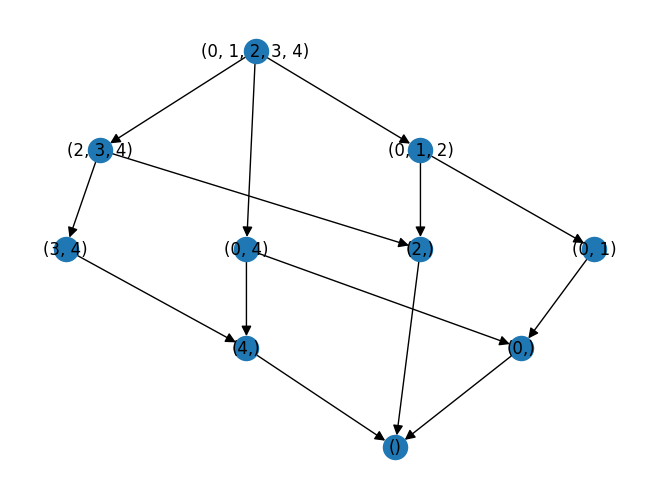

In [129]:
l = lattice(scale_lat)

lrev = nx.DiGraph.reverse(l) 
# We reverse the lattice arrows because graphviz draws all arrows going down, 
# so if we did not do this, the top element of the lattice would appear at the bottom

pos = graphviz_layout(lrev, prog="dot")
nx.draw(lrev, pos, with_labels=True, arrowsize=15)
plt.show() 

### 3.1 Displaying the ortholattice from the Epistemic Grid

Unfortunately the 1,942-element ortholattice from the Epistemic Grid is too large for networkx to display.

In [130]:
#l = lattice(grid_lat)

#nx.draw(l)
#plt.show() 

## 4. Operations on regular sets

In [131]:
def neg(A,rel,X = None):
    """given a subset A of a compatibility frame with compatibility relation rel
    return the orthocomplement of A"""
    
    setA = set(A)
    
    if X is None:
        X = domain(rel)
        
    setX = set(X)
        
    negA = [x for x in setX if set([y for y in X if (y,x) in rel and y in setA]) == set()]
    
    return set(negA)

In [132]:
def wedge(A,B):
    """Given two subsets of a compatibility frame, return their conjunction (intersection)"""
    return A.intersection(B)

In [133]:
def vee(A,B,rel,X = None):
    """Given two subsets of a compatibility frame, return their disjunction (closure of union)"""
    return set(closure(A.union(B),rel))

For example, let's verify De Morgan's law in the ortholattice from the Epistemic Scale.

In [134]:
for A in scale_lat:
    for B in scale_lat:      
        if not vee(A,B,scale_rel) == neg(wedge(neg(A,scale_rel),neg(B,scale_rel)), scale_rel):
            print("Violation of De Morgan's law!")

Below we give the valuation of $p$ and $q$ in the Epistemic Grid used in the paper.

In [135]:
P = {(0,0),(1,0),(2,0),(3,0),(4,0),(0,1),(1,1),(2,1),(3,1),(4,1)}
Q = {(0,0),(0,1),(0,2),(0,3),(0,4),(1,0),(1,1),(1,2),(1,3),(1,4)}

In [136]:
print(P.intersection(Q))

{(0, 1), (1, 0), (1, 1), (0, 0)}


In [137]:
print(neg(P,grid_rel))

{(4, 4), (2, 4), (0, 4), (3, 4), (4, 3), (0, 3), (1, 4), (2, 3), (3, 3), (1, 3)}


In [138]:
print(neg(Q,grid_rel))

{(4, 4), (4, 0), (3, 4), (4, 3), (3, 1), (4, 2), (3, 0), (3, 3), (3, 2), (4, 1)}


In [139]:
print(neg(P.intersection(Q),grid_rel))

{(4, 4), (2, 4), (4, 0), (0, 4), (3, 4), (4, 3), (3, 1), (4, 1), (0, 3), (4, 2), (3, 0), (1, 4), (2, 3), (3, 3), (3, 2), (1, 3)}


## 5. Compatibility frames with the same refinement relation but non-isomorphic ortholattices

In [140]:
def refinement(rel,X=None):
    """Returns the set of pairs (x,y) such that y refines x (written $y\sqsubseteq x$ in the paper)
    according to compatibility relation rel"""

    if X is None:
        X = domain(rel)
    
    ref = []
    for x in X:
        for y in X:
            if {z for z in X if (z,y) in set(rel)}.issubset({z for z in X if (z,x) in set(rel)}):
                ref.append((x,y))
    return ref

In [141]:
# Consider the following two compatibility frames

rel_1 = reflexive_closure([(0,1),(1,0),(1,2),(2,1),(2,3),(3,2),(3,4),(4,3), (5,1), (1,5), (3,6), (6,3)],range(7))
rel_2 = reflexive_closure([(0,1),(1,0),(3,4),(4,3), (5,1), (1,5), (3,6), (6,3)],range(7)) # Deleted the edges (1,2), (2,1), (2,3), (3,2) from rel_1

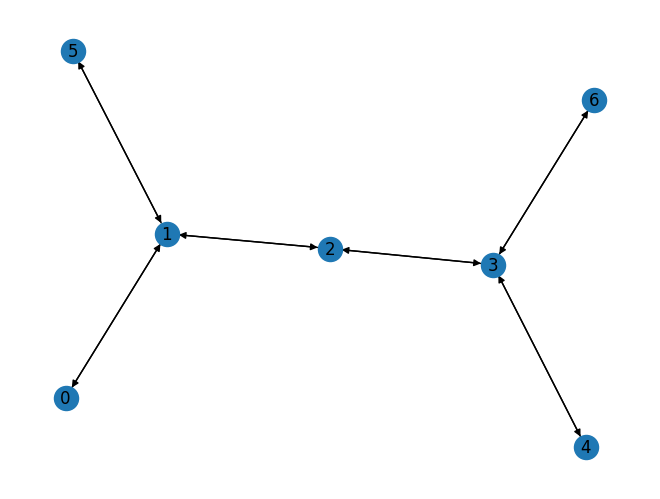

In [142]:
draw_digraph(rel_1)

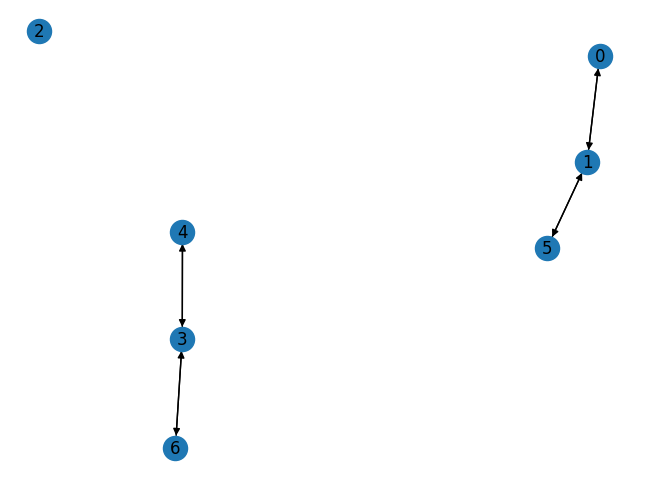

In [143]:
draw_digraph(rel_2)

In [144]:
# The ortholattices of the two frames are not isomorphic

l1_fixpts = fixpoints(rel_1)
l2_fixpts = fixpoints(rel_2)

l1 = lattice(l1_fixpts)
l2 = lattice(l2_fixpts)

nx.is_isomorphic(l1,l2)

False

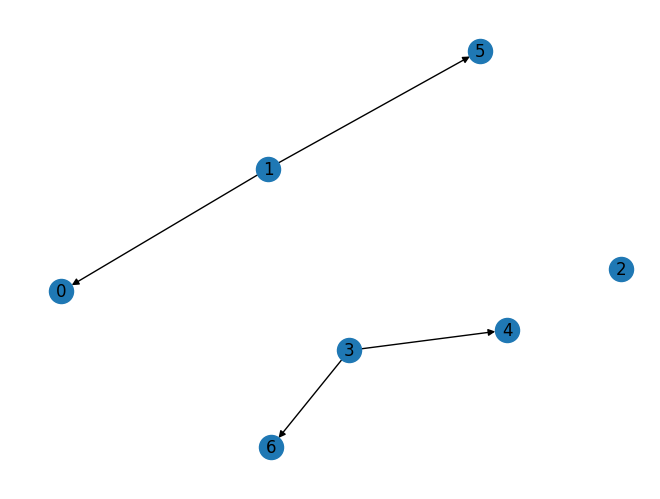

In [145]:
# The refinement relations of the two frames are the same

rel_1_ref = refinement(rel_1)
draw_digraph(rel_1_ref)

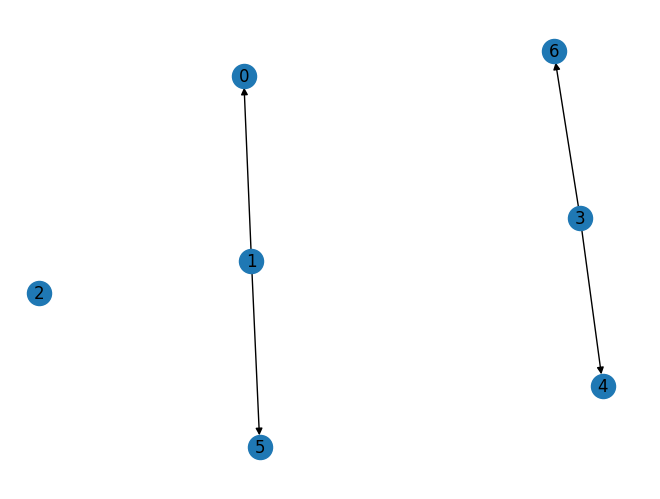

In [146]:
rel_2_ref = refinement(rel_2)
draw_digraph(rel_2_ref)

## 6. Adding accessibility

For modalities, in this notebook we use the accessibility relation representation instead of the accessibility function representation in order to use fewer possibilities in our frames.

In [147]:
def box(A, access, X = None):
    """given a subset A of a compatibility frame with accessibility relation access
    return Box A"""
    
    setA = set(A)
    
    if X is None:
        X = domain(access)
        
    BoxA = [x for x in setA if set([y for y in X if (x,y) in access]).issubset(setA)]
    
    return set(BoxA)

In [148]:
def diamond(A, rel, access, X = None):
    """given a subset A of a compatibility frame with accessibility relation access
    return Diamond A"""
    
    if X is None:
        X = domain(access)
    
    return neg(box(neg(A,rel),access),rel)

### 6.1 Accessibility for the Epistemic Scale

In [149]:
access_on_scale = reflexive_closure([(1,0),(1,2),(3,2),(3,4)],range(5))

The following test ensures that for every regular subset $A$ of the Epistemic Grid, $\Box A$ is also regular.

In [150]:
for A in scale_lat:
    boxA = box(A,access_on_scale)
    print(f"A is {A}")
    print(f"Box A is {boxA}")
    print("\n")

A is set()
Box A is set()


A is {4}
Box A is {4}


A is {3, 4}
Box A is {4}


A is {2}
Box A is {2}


A is {2, 3, 4}
Box A is {2, 3, 4}


A is {0}
Box A is {0}


A is {0, 4}
Box A is {0, 4}


A is {0, 1}
Box A is {0}


A is {0, 1, 2}
Box A is {0, 1, 2}


A is {0, 1, 2, 3, 4}
Box A is {0, 1, 2, 3, 4}




### 6.2 Accessibility for the Epistemic Grid

In [151]:
access_on_grid = reflexive_closure([((1,0),(0,0)), ((1,0),(2,0)), ((3,0),(2,0)), ((3,0),(4,0)),
                                    ((1,1),(0,1)), ((1,1),(2,1)), ((3,1),(2,1)), ((3,1),(4,1)),
                                    ((1,2),(0,2)), ((1,2),(2,2)), ((3,2),(2,2)), ((3,2),(4,2)),
                                    ((1,3),(0,3)), ((1,3),(2,3)), ((3,3),(2,3)), ((3,3),(4,3)),
                                    ((1,4),(0,4)), ((1,4),(2,4)), ((3,4),(2,4)), ((3,4),(4,4)),
                                    
                                    ((0,1),(0,0)), ((0,1),(0,2)), ((0,3),(0,2)), ((0,3),(0,4)),
                                    ((1,1),(1,0)), ((1,1),(1,2)), ((1,3),(1,2)), ((1,3),(1,4)),
                                    ((2,1),(2,0)), ((2,1),(2,2)), ((2,3),(2,2)), ((2,3),(2,4)),
                                    ((3,1),(3,0)), ((3,1),(3,2)), ((3,3),(3,2)), ((3,3),(3,4)),
                                    ((4,1),(4,0)), ((4,1),(4,2)), ((4,3),(4,2)), ((4,3),(4,4)),
                                    
                                    ((1,1),(0,0)), ((1,1),(2,0)), ((1,1),(2,2)), ((1,1),(0,2)),
                                    ((3,1),(2,0)), ((3,1),(2,2)), ((3,1),(4,2)), ((3,1),(4,0)),
                                    ((1,3),(0,2)), ((1,3),(0,4)), ((1,3),(2,4)), ((1,3),(2,2)),
                                    ((3,3),(2,2)), ((3,3),(4,2)), ((3,3),(4,4)), ((3,3),(2,4))], 
                                   
                                   prod)

The following test ensures that for every regular subset $A$ of the Epistemic Grid, $\Box A$ is also regular.

In [152]:
for A in grid_lat:
    boxA = box(A,access_on_grid)
    if boxA not in grid_lat:
        print("Box of this regular set is not regular!")
        print(A)
        print(boxA)
        print("\n")

We now calculate the truth values of some formulas using the valuation for $p$ and $q$ on the Epistemic Grid.

In [153]:
#Recall the valuation of p and q on the Epistemic Grid

P = {(0,0),(1,0),(2,0),(3,0),(4,0),(0,1),(1,1),(2,1),(3,1),(4,1)}
Q = {(0,0),(0,1),(0,2),(0,3),(0,4),(1,0),(1,1),(1,2),(1,3),(1,4)}

In [154]:
diamond_P = diamond(P,grid_rel,access_on_grid)
print(diamond_P)

{(0, 1), (1, 2), (4, 0), (2, 1), (0, 0), (3, 1), (1, 1), (2, 0), (4, 2), (3, 0), (0, 2), (2, 2), (1, 0), (3, 2), (4, 1)}


In [155]:
diamond_Q = diamond(Q,grid_rel,access_on_grid)
print(diamond_Q)

{(0, 1), (2, 4), (1, 2), (0, 4), (2, 1), (0, 0), (1, 1), (0, 3), (2, 0), (1, 4), (2, 3), (0, 2), (2, 2), (1, 0), (1, 3)}


In [156]:
print(wedge(diamond_P,diamond_Q))

{(0, 1), (1, 2), (2, 1), (0, 0), (1, 1), (2, 0), (0, 2), (2, 2), (1, 0)}


In [157]:
print(diamond(wedge(P,Q),grid_rel,access_on_grid))

{(0, 1), (1, 2), (2, 1), (0, 0), (1, 1), (2, 0), (0, 2), (2, 2), (1, 0)}


# 7. Interpreting formulas

We take formulas to be strings and use the following symbols:

'~' for negation;

'L' for must;

'M' for might;

'^' for conjunction;

'v' for disjunction.

In [158]:
def main_connective(formula):
    """
    Returns the main connective of the formula (or "prop" if s is a propositional variable) and 
    arguments to main connective (or propositional variable)
    """

    formula = formula.replace(" ", "")
        
    if len(formula) == 1:
        return "prop", formula

    if formula.startswith("~"):
        formula = formula.removeprefix("~")
        return "~", formula
    
    if formula.startswith("L"):
        formula = formula.removeprefix("L")
        return "L", formula

    if formula.startswith("M"):
        formula = formula.removeprefix("M")
        return "M", formula

    if formula.startswith("("):
            
        leftparen = 0
        rightparen = 0
        slength = len(formula)

        for n in range(slength):

            if formula[n] == "(":
                leftparen +=1

            if formula[n] == ")":
                rightparen +=1

            if leftparen - rightparen == 1:
                
                if formula[n] == "^":
                    return "^", formula[1:n], formula[n+1:-1]

                if formula[n] == "v":
                    return "v", formula[1:n], formula[n+1:-1] 

    return None

In [159]:
def extension(formula, compat_rel, access_rel, valuation):
    """
    Given a formula, compatibility and accessibility relations, and a valuation,
    returns the extension of the formula as a set of possibilities
    """
    dom = domain(access_rel)
    
    main_connec = main_connective(formula)

    if main_connec[0] == 'prop':

        return set([x for x in dom if x in valuation[main_connec[1]]])

    if main_connec[0] == '~':
        inner_ext = set(extension(main_connec[1],compat_rel,access_rel,valuation))
        return neg(inner_ext, compat_rel)

    if main_connec[0] == 'L':
        inner_ext = set(extension(main_connec[1],compat_rel,access_rel,valuation))
        return box(inner_ext,access_rel)
    
    if main_connec[0] == 'M':
        inner_ext = set(extension(main_connec[1],compat_rel,access_rel,valuation))
        return diamond(inner_ext,compat_rel,access_rel)

    if main_connec[0] == '^':
        left_ext = extension(main_connec[1],compat_rel,access_rel,valuation)
        right_ext = extension(main_connec[2],compat_rel,access_rel,valuation)
        return wedge(left_ext,right_ext)

    if main_connec[0] == 'v':
        left_ext = extension(main_connec[1],compat_rel,access_rel,valuation)
        right_ext = extension(main_connec[2],compat_rel,access_rel,valuation)
        return vee(left_ext,right_ext,compat_rel)

In [160]:
scale_val = {'p': set({0,1})}

print("Extension of Lp:", extension('Lp',scale_rel,access_on_scale,scale_val))
print("Extension of p:", extension('p',scale_rel,access_on_scale,scale_val))
print("Extension of Mp:", extension('Mp',scale_rel,access_on_scale,scale_val))
print("Extension of (Mp ^ M~p):", extension('(Mp ^ M~p)',scale_rel,access_on_scale,scale_val))
print("Extension of M~p:", extension('M~p',scale_rel,access_on_scale,scale_val))
print("Extension of ~p:", extension('~p',scale_rel,access_on_scale,scale_val))
print("Extension of L~p:", extension('L~p',scale_rel,access_on_scale,scale_val))

Extension of Lp: {0}
Extension of p: {0, 1}
Extension of Mp: {0, 1, 2}
Extension of (Mp ^ M~p): {2}
Extension of M~p: {2, 3, 4}
Extension of ~p: {3, 4}
Extension of L~p: {4}


In [161]:
grid_val = {'p': {(0,0),(1,0),(2,0),(3,0),(4,0),(0,1),(1,1),(2,1),(3,1),(4,1)}, 'q': {(0,0),(0,1),(0,2),(0,3),(0,4),(1,0),(1,1),(1,2),(1,3),(1,4)}}

print("Extension of Lp:", extension('Lp',grid_rel,access_on_grid,grid_val))
print("Extension of p:", extension('p',grid_rel,access_on_grid,grid_val))
print("Extension of Mp:", extension('Mp',grid_rel,access_on_grid,grid_val))
print("Extension of (Mp ^ M~p):", extension('(Mp ^ M~p)',grid_rel,access_on_grid,grid_val))
print("Extension of M~p:", extension('M~p',grid_rel,access_on_grid,grid_val))
print("Extension of ~p:", extension('~p',grid_rel,access_on_grid,grid_val))
print("Extension of L~p:", extension('L~p',grid_rel,access_on_grid,grid_val))
print("")
print("Extension of Lq:", extension('Lq',grid_rel,access_on_grid,grid_val))
print("Extension of q:", extension('q',grid_rel,access_on_grid,grid_val))
print("Extension of Mq:", extension('Mq',grid_rel,access_on_grid,grid_val))
print("Extension of (Mq ^ M~q):", extension('(Mq ^ M~q)',grid_rel,access_on_grid,grid_val))
print("Extension of M~q:", extension('M~q',grid_rel,access_on_grid,grid_val))
print("Extension of ~q:", extension('~q',grid_rel,access_on_grid,grid_val))
print("Extension of L~q:", extension('L~q',grid_rel,access_on_grid,grid_val))

Extension of Lp: {(4, 0), (0, 0), (2, 0), (3, 0), (1, 0)}
Extension of p: {(0, 1), (4, 0), (2, 1), (0, 0), (3, 1), (1, 1), (2, 0), (3, 0), (1, 0), (4, 1)}
Extension of Mp: {(0, 1), (1, 2), (4, 0), (2, 1), (0, 0), (3, 1), (1, 1), (2, 0), (4, 2), (3, 0), (0, 2), (2, 2), (1, 0), (3, 2), (4, 1)}
Extension of (Mp ^ M~p): {(1, 2), (4, 2), (0, 2), (2, 2), (3, 2)}
Extension of M~p: {(4, 4), (2, 4), (1, 2), (0, 4), (3, 4), (4, 3), (0, 3), (4, 2), (1, 4), (2, 3), (0, 2), (3, 3), (2, 2), (3, 2), (1, 3)}
Extension of ~p: {(4, 4), (2, 4), (0, 4), (3, 4), (4, 3), (0, 3), (1, 4), (2, 3), (3, 3), (1, 3)}
Extension of L~p: {(4, 4), (2, 4), (0, 4), (3, 4), (1, 4)}

Extension of Lq: {(0, 1), (0, 4), (0, 0), (0, 3), (0, 2)}
Extension of q: {(0, 1), (1, 2), (0, 4), (0, 0), (1, 1), (0, 3), (1, 4), (0, 2), (1, 0), (1, 3)}
Extension of Mq: {(0, 1), (2, 4), (1, 2), (0, 4), (2, 1), (0, 0), (1, 1), (0, 3), (2, 0), (1, 4), (2, 3), (0, 2), (2, 2), (1, 0), (1, 3)}
Extension of (Mq ^ M~q): {(2, 4), (2, 1), (2, 0), (

In [162]:
# Note that in the epistemic grid we can distribute 'might p' over 'q or not q':

extension('(Mp ^ (q v ~q))',grid_rel,access_on_grid,grid_val) == extension('((Mp ^ q) v (Mp ^ ~q))',grid_rel,access_on_grid,grid_val)

True

# 8. Epistemic Levels  

In [163]:
def one_step_ortho_closure(prop,rel):
    "given a list props of propositions, add their negations (relative to rel) and pairwise intersections"
    close = copy.deepcopy(prop)

    for A in prop:
        negA = neg(A,rel)
        if negA not in close:
            close.append(neg(A,rel))

    for A in prop:
        for B in prop:
            AandB = wedge(A,B)
            if AandB not in close:
                close.append(wedge(A,B))

    return close

In [164]:
one_step = one_step_ortho_closure([{0,1}],scale_rel)

print(one_step)

two_step = one_step_ortho_closure(one_step,scale_rel)

print(two_step)

three_step = one_step_ortho_closure(two_step,scale_rel)

print(three_step)

[{0, 1}, {3, 4}]
[{0, 1}, {3, 4}, set()]
[{0, 1}, {3, 4}, set(), {0, 1, 2, 3, 4}]


In [165]:
def ortho_closure(props, rel):
    "given a list props of propositions, take the closure under negation (relative to rel) and binary intersection"
    close = copy.deepcopy(props)

    while not close == one_step_ortho_closure(close,rel):
        close = one_step_ortho_closure(close,rel)

    return close

In [166]:
ortho_closure([{0,1}],scale_rel)

[{0, 1}, {3, 4}, set(), {0, 1, 2, 3, 4}]

In [167]:
left_two_columns = set([(i,0) for i in range(5)] + [(i,1) for i in range (5)])
top_two_rows = set([(0,i) for i in range(5)] + [(1,i) for i in range (5)])

len(ortho_closure([left_two_columns, top_two_rows],grid_rel))

16

In [168]:
def check_Boolean(props,rel):
    "given a list props of propositions, check whether the condition guaranteeing Booleaness in Proposition 4.40 holds"
    for A in props:
        for B in props:
            for x in A:
                for y in B:
                    if (x,y) in rel:
                        if len([z for z in A if z in B]) == 0:
                            print("A is", A)
                            print("B is ",B)
                            print("x is", x)
                            print("y is ",y)
                            return False
    
    return True

In [169]:
B = fixpoints(scale_rel)

check_Boolean(B, scale_rel)

A is {3, 4}
B is  {2}
x is 3
y is  2


False

In [170]:
B = ortho_closure([{0,1}],scale_rel)

check_Boolean(B, scale_rel)

True

In [171]:
def boxed_elements(props,access):
    "given a list props of propositions, return a list of all the boxed propositions"
    boxed = []

    for A in props:
        boxed.append(box(A,access))

    return boxed

In [172]:
B0 = ortho_closure([{0,1}],scale_rel)

ortho_closure(boxed_elements(B0,access_on_scale),scale_rel)

[{0}, {4}, set(), {0, 1, 2, 3, 4}, {2, 3, 4}, {0, 1, 2}, {2}, {0, 4}]

In [173]:
def epistemic_level(rel, access, B, n):
    "given a compatibility and accessibility relations and distinguished propositions in B, return the set B_n from Definition 3.31"
    if n == 0:
        return ortho_closure(B,rel)
    
    if n > 0: 
       return ortho_closure(boxed_elements(epistemic_level(rel,access,B,n-1),access),rel) 

In [174]:
epistemic_level(scale_rel,access_on_scale, [{0,1}],0)

[{0, 1}, {3, 4}, set(), {0, 1, 2, 3, 4}]

In [175]:
epistemic_level(scale_rel,access_on_scale, [{0,1}],1)

[{0}, {4}, set(), {0, 1, 2, 3, 4}, {2, 3, 4}, {0, 1, 2}, {2}, {0, 4}]

In [176]:
epistemic_level(scale_rel,access_on_scale, [{0,1}],2)

[{0}, {4}, set(), {0, 1, 2, 3, 4}, {2, 3, 4}, {0, 1, 2}, {2}, {0, 4}]

In [177]:
check_Boolean(epistemic_level(scale_rel,access_on_scale, [{0,1}],1), scale_rel)

True

In [178]:
len(epistemic_level(grid_rel,access_on_grid, [left_two_columns, top_two_rows],0))

16

In [179]:
len(epistemic_level(grid_rel,access_on_grid, [left_two_columns, top_two_rows],1))

512

In [180]:
len(epistemic_level(grid_rel,access_on_grid, [left_two_columns, top_two_rows],2))

512

In [181]:
check_Boolean(epistemic_level(grid_rel,access_on_grid, [left_two_columns, top_two_rows],1), grid_rel)

True

In [182]:
def stratified(rel, access, B):
    "check whether the given grounded modal compatibility frame is stratified as in Definition 4.39"
    n = 0

    if not check_Boolean(epistemic_level(rel,access, B, 0), rel):
        return False

    while not epistemic_level(rel,access,B,n+1) == epistemic_level(rel,access,B,n):
        
        if not check_Boolean(epistemic_level(rel,access, B, n+1), rel):
            return False 

        n += 1

    return True

In [183]:
stratified(scale_rel,access_on_scale,[{0,1}])

True

In [184]:
stratified(grid_rel,access_on_grid, [left_two_columns, top_two_rows])

True